<center><h1>Neuroscience Final Project</h1></center>
<center><h2>Deep Q Networks</h2></center>

In this notebook, we are going to get familiar with Deep Q Networks. You have been introduced to Reinforcement Learning in the course. Deep Q Networks are an entension of Reinforcement Learning were we incorporate Deep Neural Networks in our policy enhacement procedure.

We also implement an Agent in an online learning environment, meaning that the agent has no initial memory of the rewards in each state. We go through the environment based on our policy and store the observed rewards and corresponding state in the memory of the agent

Finally, we utilize the Agent in a practical Maze Solving problem. The agent is prompted to iterate the maze from a defined starting point to an ending point, maximing the profit from the total route.

**Name** : Armin Navardi

**Student ID**: 99105129

## Importing the necessary packages

In [6]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Creating the Deep Q Network

In [7]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(input_dims[0], fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        # Calculate the forward pass. Use Proper non-linear activation function between the linear layers
        x = T.relu(self.fc1(state))
        x = T.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions

## Creating the Agent

In [8]:
class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0

        # Create an instance of te Deep Q network with 256 neurons in each of its hidden layers
        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)


    # Store one episode alongside its reward, state, next_state
    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1


    # Choose the best action with probability (1 - epsilon), otherwise choose a random direction from the action space
    # The best action is defined as the maximum output of the Deep Q Network
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation], dtype=T.float).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    # Train the Deep Q Network based on the new observations
    # The network must learn the target Q values through regression
    def learn(self):
        # Simply ignore the training phase if there is not enough memory stored yet
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        # Choose a random batch of data from the memory
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice( max_mem, self.batch_size, replace=False)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(
                self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
                self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(
                self.terminal_memory[batch]).to(self.Q_eval.device)

        # Current state Q-value as predicted by the network
        # Note to filter the matrix to only q-values corresponding to our "action_batch"
        q_eval = self.Q_eval.forward(state_batch)[np.arange(self.batch_size), action_batch]

        # Next state Q-value as predicted by the network for all possible next actions
        q_next = self.Q_eval.forward(new_state_batch).max(dim=1)[0]

        # The target Q-value of our current state with a discount factor of gamma
        q_next[terminal_batch] = 0.0
        q_target = reward_batch + self.gamma * q_next

        # Make the network learn this target Q-value via a proper definitio of loss function
        loss = self.Q_eval.loss(q_eval, q_target)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1

        # Reduce the epsilon by its decay factor it possible
        self.epsilon = max(self.eps_min, self.epsilon - self.eps_dec)

## Working with the Maze environment

In [29]:
import sys
sys.path.append("/content/drive/MyDrive/Courses/Neuroscience Final Project")
from maze import MazeEnvironment
#import maze
import warnings
warnings.filterwarnings('ignore')

# Create a maze environment
# You can create a new one or use the files stored in directory mazes to load a maze
env = MazeEnvironment(50, "/content/drive/MyDrive/Courses/Neuroscience Final Project/mazes/maze1.npy")

agent = Agent(gamma=0.99, epsilon=1, batch_size=15, n_actions=4, eps_end=0.01, input_dims=[2], lr=0.01)
scores = []
n_games = 50

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    counter = 0
    while not done:
        counter += 1
        # If performed 1000 moves and didn't finish the maze, reset the environment
        if (counter == 1000):
            counter = 0
            score = 0
            observation = env.reset()
            break

        # Make the agent choose an action
        action = agent.choose_action(observation)

        # Retrieve the reward and next_state from the envirinment
        observation_, reward, done = env.step(action)

        score += reward

        # Store the current episode in the memory
        agent.store_transition(observation, action, reward, observation_, done)

        # Learn the current episode
        agent.learn()

        # Change the next state to the current state
        observation = observation_

    scores.append(score)

    avg_score = np.mean(scores[-100:])

    print('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon)

episode  0 score 0.00 average score 0.00 epsilon 0.51
episode  1 score 912.00 average score 456.00 epsilon 0.12
episode  2 score 0.00 average score 304.00 epsilon 0.01
episode  3 score 0.00 average score 228.00 epsilon 0.01
episode  4 score 0.00 average score 182.40 epsilon 0.01
episode  5 score 0.00 average score 152.00 epsilon 0.01
episode  6 score 0.00 average score 130.29 epsilon 0.01
episode  7 score 5212.00 average score 765.50 epsilon 0.01
episode  8 score 2497.00 average score 957.89 epsilon 0.01
episode  9 score 2393.00 average score 1101.40 epsilon 0.01
episode  10 score 0.00 average score 1001.27 epsilon 0.01
episode  11 score 14045.00 average score 2088.25 epsilon 0.01
episode  12 score 6013.00 average score 2390.15 epsilon 0.01
episode  13 score 5587.00 average score 2618.50 epsilon 0.01
episode  14 score 392.00 average score 2470.07 epsilon 0.01
episode  15 score 3906.00 average score 2559.81 epsilon 0.01
episode  16 score 1202.00 average score 2479.94 epsilon 0.01
episod

score max: 14279.0


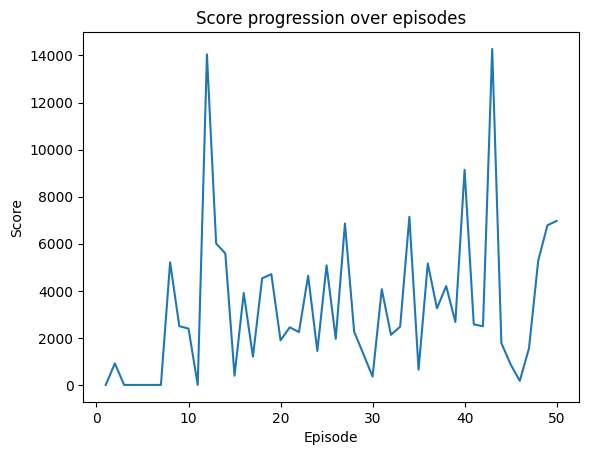

In [34]:
import matplotlib.pyplot as plt

# Maximum score
print(f"score max: {np.max(scores)}")

plt.plot([i+1 for i in range(n_games)], scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Score progression over episodes')
plt.show()



[[ 7.  2.  8. ... -2. -5.  8.]
 [-3. 41. -6. ...  3.  7. -8.]
 [ 0. -7. 43. ... -8. -2. -8.]
 ...
 [-2. -8.  6. ... 32.  8.  3.]
 [ 0. -2.  2. ... -6. 45. -2.]
 [ 2.  3. -8. ...  0. -8. 95.]]
2017.0


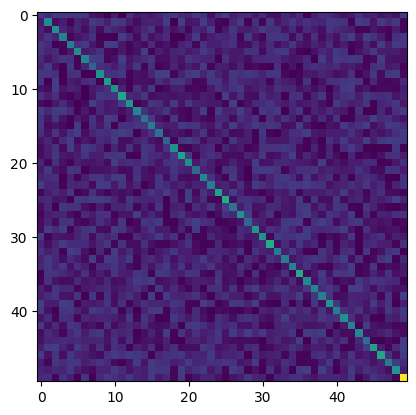

In [33]:
import matplotlib.pyplot as plt

plt.imshow(env.maze)
print(env.maze)
print(np.trace(env.maze))

## Report

Try to manipulate constants such as batch_size, epsilon, gamma, .... Try to achieve the maximum score.

Grading will not be based on the best scores. However, higher scores can bring bonus grade!

Plot the incrementation of your score through n games and try to justify the patterns.

As we can see, score per episode is increasing on average and has a upward trend meaning the agent is learning better policies on average. However, there are some fluctuations in the scores. These fluctuations are do to the stochastic policy and huge changes in the policy network due to the gradient descent algoirthm. This can be solved by using proximal policy optimization which clips the policy differences and limits policy updates which results in stable learning.

## (Bonus) Target Q Network

Instead of calculating the target q-value using the formula presented, you can use anonther Deep Neural Network to predict the target Q-values via regression!

Implementing the target Q network alonside the eval Q network can lead to more steady behavior of the final score.